In [39]:
import pint
si = pint.UnitRegistry()

In [40]:
from scipy.stats import lognorm

In [41]:
%run parcel.ipynb

In [42]:
%matplotlib notebook
import matplotlib.pyplot as plt
si.setup_matplotlib()

In [43]:
size = 100
epsilon = 5

a = np.array([10]).reshape(-1,1)
b = np.full((1,50), size - epsilon)
c= np.full((1,50), size + epsilon)

d = np.full((1, np.size(b) + np.size(c) ), size)


# Realizacja 1) - 50 kropel większych, 50 mniejszych
rd1 = np.concatenate((a,b,c),axis = 1).reshape(101,) * si.nanometre

# Realizacja 2) - 100 kropel w średnim rozmiarze
rd2 = np.concatenate((a,d),axis = 1).reshape(101,) * si.nanometre

In [44]:
rd1
rd2

array([ 10, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100]) <Unit('nanometer')>

In [53]:
rm = 50 * si.nanometre
sg = 1.4

nd1 = lognorm.pdf(rd1, log(sg), 0, rm)
nd1 *= 1000 / np.sum(nd1) / si.milligram

dr1 = rd1[1:] - rd1[0:-1]
dn_dr1 = nd1[0:-1] / dr1


nd2 = lognorm.pdf(rd2, log(sg), 0, rm)
nd2 *= 1000 / np.sum(nd2) / si.milligram

dr2 = rd2[1:] - rd2[0:-1]
dn_dr2 = nd2[0:-1] / dr2

In [48]:
# plt.figure(figsize=(4,4))
# plt.plot(rd1[0:-1], dn_dr)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e1, 1e3)
# plt.ylim(1e-9, 1e3)
# plt.yticks(10.**np.arange(-8, 3, step=2))  

In [54]:
integ1, sys1 = parcel(
    si = si,
    t = 40 * si.seconds,
    T0 = 300 * si.kelvin,
    q0 = 21 * si.grams / si.kilogram,
    p0 = 1000 * si.hectopascals,
    w = lambda t: 10* si.metre / si.second,
    nd = nd1, 
    rd = rd1, 
    kp = 1.28,
    dt_max = 0.05 * si.second
)

In [55]:
integ2, sys2 = parcel(
    si = si,
    t = 40 * si.seconds,
    T0 = 300 * si.kelvin,
    q0 = 21 * si.grams / si.kilogram,
    p0 = 1000 * si.hectopascals,
    w = lambda t: 10* si.metre / si.second,
    nd = nd2, 
    rd = rd2, 
    kp = 1.28,
    dt_max = 0.05 * si.second
)

In [56]:
ix = sys.ix
fn = sys.fn
ph = sys.ph

In [57]:
T1 = integ1.y[ix.T] * ix.T_unit
p1 = integ1.y[ix.p] * ix.p_unit
q1 = integ1.y[ix.q] * ix.q_unit
r1 = fn.r(integ1.y[ix.x] * ix.x_unit)
t1 = integ1.t * ix.t_unit

dr_dt1 = np.empty_like(r) * ix.r_unit / ix.t_unit
for i, tau in enumerate(integ1.t):
    y = integ1.y[:, i]
    dx_dt = sys1(tau, y)[ix.x] * ix.x_unit / ix.t_unit
    x = y[ix.x] * ix.x_unit
    dr_dt1.magnitude[:, i] = dx_dt / fn.dx_dr(fn.r(x))

In [58]:
T2 = integ2.y[ix.T] * ix.T_unit
p2 = integ2.y[ix.p] * ix.p_unit
q2 = integ2.y[ix.q] * ix.q_unit
r2 = fn.r(integ2.y[ix.x] * ix.x_unit)
t2 = integ2.t * ix.t_unit

dr_dt2 = np.empty_like(r) * ix.r_unit / ix.t_unit
for i, tau in enumerate(integ2.t):
    y = integ2.y[:, i]
    dx_dt = sys2(tau, y)[ix.x] * ix.x_unit / ix.t_unit
    x = y[ix.x] * ix.x_unit
    dr_dt2.magnitude[:, i] = dx_dt / fn.dx_dr(fn.r(x))



100 x 1um  VS 50 x 0.95 um + 50 x 1.05 um,   porównać przesycenia

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,4))

plt.xticks([])
plt.yticks([])
ax1.set_ylim([0, 42])

ax1.plot(T1, t, label="T")
ax1.grid()
ax1.legend()
ax1.xaxis.set_units(si.celsius)

ax2.plot(p1, t, label="p")
ax2.grid()
ax2.legend()
ax2.xaxis.set_units(si.hectopascals)

ax3.plot(ph.RH(T1, p1, q1), t, label="RH")
ax3.grid()
ax3.legend()

<IPython.core.display.Javascript object>

ValueError: Cannot operate with Unit and Unit of different registries.

### Nazwa notebooka lekko oszukana, bo  $A,B \neq 0 $

<IPython.core.display.Javascript object>


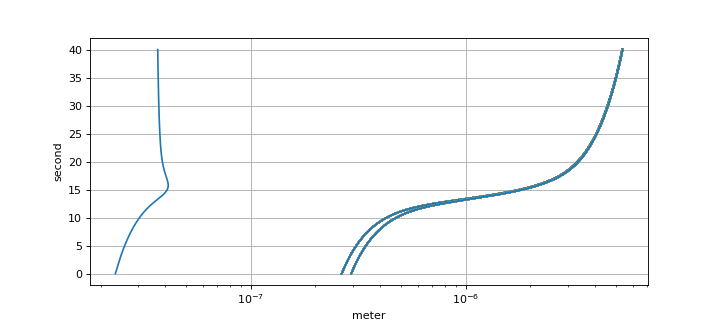

In [73]:
plt.figure(figsize=(9,4))
for i in range(ix.x.stop - ix.x.start):
    plt.plot(r1[i], t, label="r_"+str(i))

plt.xscale('log')
# plt.yscale('log')
plt.grid()
# plt.legend()

plt.show()

<IPython.core.display.Javascript object>


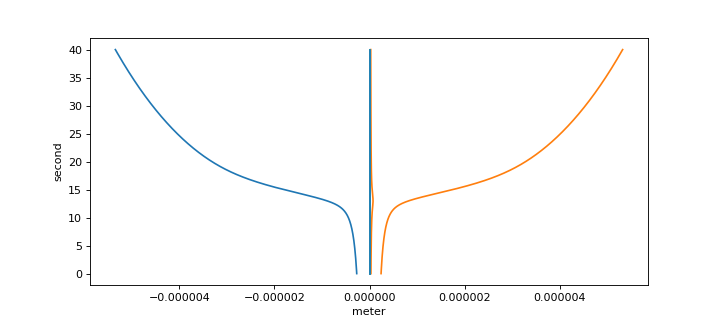

In [72]:
plt.figure(figsize=(9,4))
for i in range(0,ix.x.stop - ix.x.start):
    plt.plot(r1[i]-r1[i-1], t, label="r_"+str(i))
# plt.xscale('log')
# plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


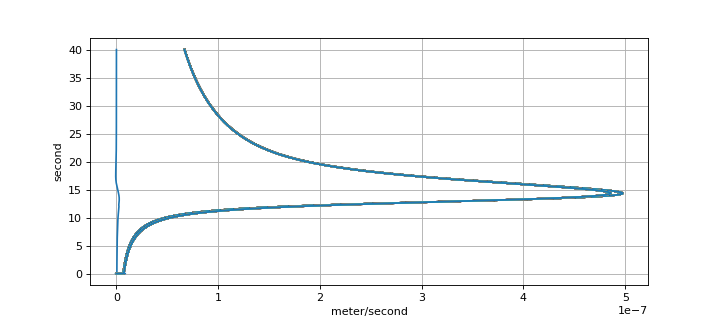

In [71]:
plt.figure(figsize=(9,4))
for i in range(ix.x.stop - ix.x.start):
    plt.plot(dr_dt1[i], t, label="dr_dt_"+str(i))

# plt.xscale('log')
# plt.yscale('log')
plt.grid()
# plt.legend()

plt.show()

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,4))

plt.xticks([])
plt.yticks([])
ax1.set_ylim([0, 42])

ax1.plot(dr_dt1[0], t, label="r1")
ax1.grid()
ax1.legend()
ax1.xaxis.set_units(si.metre)

ax2.plot(dr_dt1[1], t, label="r2")
ax2.grid()
ax2.legend()
ax2.xaxis.set_units(si.metre)

<IPython.core.display.Javascript object>

ValueError: Cannot operate with Unit and Unit of different registries.